In [ ]:
# !pip install transformers

In [1]:
import os, gc, sys, time, collections, random
import numpy as np
import pandas as pd

from typing import Dict, Optional, Union, Any, List, Tuple

from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn

import torch.utils.data as D
from torch.utils.data.dataset import Dataset, IterableDataset
from torch.utils.data.dataloader import DataLoader

from transformers import DistilBertTokenizerFast
from transformers import DistilBertModel
from transformers import BertTokenizerFast
from transformers import BertModel
from transformers import Trainer
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers.data.processors.utils import InputFeatures
from transformers import TrainingArguments
from transformers.trainer_utils import EvalLoopOutput
from transformers.trainer import logging
from transformers.file_utils import is_torch_tpu_available, is_sagemaker_mp_enabled
from transformers.trainer_pt_utils import find_batch_size, nested_concat, nested_numpify, nested_truncate, nested_detach

### Folders and Dataframes

In [2]:
DATA_PATH = Path('/home/commonlit/data/')
assert DATA_PATH.exists()
MODELS_PATH = Path('/home/commonlit/models/')
if not MODELS_PATH.exists():
    os.mkdir(MODELS_PATH)
assert MODELS_PATH.exists()

In [3]:
!ls {DATA_PATH}

commonlit_lm		       the_huge_hunter.txt
commonlit_lm.zip	       the_twin_stars.txt
commonlitreadabilityprize.zip  thumbelina
data_enhancements.ipynb        train-orig.csv
mapping_the_oceans.txt	       train.csv
pecks_uncle_ike.txt	       train_duo.csv
sample_submission.csv	       train_enhancements.csv
sports_in_adolescence.txt      understood_betsy.txt
stories_for_little_boys.txt    why_the_swallows_tail_is_forked.txt
test.csv


In [4]:
train_df = pd.read_csv(DATA_PATH/'train.csv')
test_df = pd.read_csv(DATA_PATH/'test.csv')
sample_df = pd.read_csv(DATA_PATH/'sample_submission.csv')

In [5]:
train_df

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
2,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009
3,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009
4,c12129c31,NaN,NaN,"At last the game was concluded, as Roger Farri...",-0.340259,0.464009
...,...,...,...,...,...,...
2923,e48f075f9,https://kids.frontiersin.org/article/10.3389/f...,CC BY 4.0,There are heaps of different things that can s...,-0.451736,0.469100
2924,e48f075f9,https://kids.frontiersin.org/article/10.3389/f...,CC BY 4.0,But we will also talk about how getting a conc...,-0.451736,0.469100
2925,e48f075f9,https://kids.frontiersin.org/article/10.3389/f...,CC BY 4.0,The brain goes through a lot of changes during...,-0.451736,0.469100
2926,e48f075f9,https://kids.frontiersin.org/article/10.3389/f...,CC BY 4.0,"During adolescence, the white matter begins to...",-0.451736,0.469100


In [6]:
train_df[train_df['excerpt'].str.contains('Robin Hood')]

,id,url_legal,license,excerpt,target,standard_error
231,21ea485fb,NaN,NaN,A little within the wood there was a fair cast...,-1.302688,0.450399
233,a04741371,NaN,NaN,"The king dwelt for many months in Nottingham, ...",-0.714009,0.506864
234,5cb5ab998,NaN,NaN,"When they drew near Nottingham, all the people...",-1.541347,0.478166
235,622f6215e,NaN,NaN,About this time there was living in Nottingham...,-2.054284,0.538084


In [7]:
train_df[train_df['id'] == '21ea485fb']['excerpt'].values

array(['A little within the wood there was a fair castle, with a double moat, and surrounded by stout walls. Here dwelt that noble knight, Sir Richard Lee, to whom Robin Hood had lent the four hundred pounds to redeem his land.\nHe saw the little company of outlaws fighting their way along, so he hastened to call them to come and take shelter in his castle.\n"Welcome art thou, Robin Hood! Welcome!" he cried, as he led them in. "Much I thank thee for thy comfort and courtesy and great kindness to me in the forest. There is no man in the world I love so much as thee. For all the proud Sheriff of Nottingham, here thou shalt be safe!—Shut the gates, and draw the bridge, and let no man come in!" he shouted to his retainers. "Arm you well; make ready; guard the walls! One thing, Robin, I promise thee: here shalt thou stay for twelve days as my guest, to sup, and eat, and dine."\nSwiftly and readily tables were laid and cloths spread, and Robin Hood and his merry men sat down to a good meal.'

In [8]:
train_df[train_df['id'] == '0bf29d257']['target']

1305   -3.351956
1306   -3.351956
Name: target, dtype: float64

### Normalize

In [9]:
train_df['target'].describe()

count    2928.000000
mean       -0.935530
std         1.040718
min        -3.676268
25%        -1.681407
50%        -0.875757
75%        -0.159258
max         1.711390
Name: target, dtype: float64

In [10]:
train_target_mean = train_df['target'].mean()
train_target_std = train_df['target'].std()
train_df['normalized_target'] = (train_df['target'] - train_target_mean) / train_target_std

In [11]:
train_target_mean, train_target_std

(-0.9355302017117486, 1.040717901616821)

In [12]:
train_df['normalized_target'].describe()

count    2.928000e+03
mean    -2.426717e-17
std      1.000000e+00
min     -2.633507e+00
25%     -7.166943e-01
50%      5.743453e-02
75%      7.459011e-01
max      2.543360e+00
Name: normalized_target, dtype: float64

In [13]:
train_df['normalized_target_check'] = train_df['normalized_target'] * train_target_std + train_target_mean

In [14]:
train_df.head(30)

,id,url_legal,license,excerpt,target,standard_error,normalized_target,normalized_target_check
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,0.571981,-0.340259
1,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,0.571981,-0.340259
2,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009,0.571981,-0.340259
3,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009,0.571981,-0.340259
4,c12129c31,NaN,NaN,"At last the game was concluded, as Roger Farri...",-0.340259,0.464009,0.571981,-0.340259
5,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,0.595894,-0.315372
6,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,0.341507,-0.580118
7,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,-0.113848,-1.054013
8,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,-0.113848,-1.054013
9,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,1.136454,0.247197


In [15]:
# !pip install seaborn

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='target'>

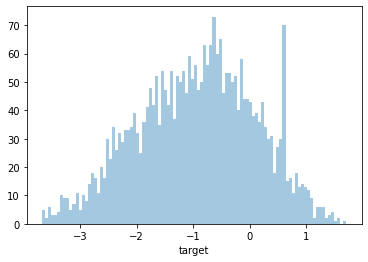

In [17]:
sns.distplot(train_df['target'],bins=100,kde=False)

### Configuration

In [18]:
import yaml

In [19]:
class CONFIG():
    batch_size = 16
    max_len = 256
    num_workers = 4
    epochs = 16
    pretrained_transformers_model = f'roberta-base'
    target_field = 'target'

In [20]:
cfg = CONFIG()
cfg.model_name = 'roberta-base'
cfg.num_folds = 12

In [21]:
cfg.train_target_std = float(train_target_std)
cfg.train_target_mean = float(train_target_mean)

In [22]:
# assert Path(cfg.pretrained_transformers_model).exists()

In [23]:
vars(cfg)

{'model_name': 'roberta-base',
 'num_folds': 12,
 'train_target_std': 1.040717901616821,
 'train_target_mean': -0.9355302017117486}

In [24]:
!mkdir {MODELS_PATH}/facebook

mkdir: cannot create directory ‘/home/commonlit/models/facebook’: File exists


In [25]:
with open(f'{MODELS_PATH}/{cfg.model_name}.yaml', 'w') as file:
    documents = yaml.dump(vars(cfg), file)

### Prepare Cross Validation

In [26]:
target = train_df[cfg.target_field].to_numpy()

In [27]:
# num_bins = int(np.floor(np.log2(len(train_df))) + 1)
# train_df.loc[:, 'bins'] = pd.cut(train_df[cfg.target_field], bins=num_bins, labels=False)

In [28]:
def add_bins(train_df):
    num_bins = int(np.floor(np.log2(len(train_df))) + 1)
    train_df.loc[:, 'bins'] = pd.cut(train_df[cfg.target_field], bins=num_bins, labels=False)
    return num_bins

In [29]:
num_bins = add_bins(train_df)

In [30]:
train_df[[cfg.target_field, 'bins']].groupby(['bins']).agg(['mean', 'count'])

target      
          mean count
bins                
0    -3.411708    44
1    -2.969369    79
2    -2.518891   182
3    -2.106393   269
4    -1.652995   368
5    -1.201392   420
6    -0.745424   492
7    -0.309740   427
8     0.131842   317
9     0.567749   224
10    0.978923    83
11    1.399764    23

In [31]:
kf = StratifiedKFold(n_splits=cfg.num_folds)

In [32]:
def add_kfold(train_df):
    for i, (t_, v_) in enumerate(kf.split(X=train_df, y=train_df.bins.values)):
        train_df.loc[v_, 'kfold'] = i

In [33]:
add_kfold(train_df)

In [34]:
train_df['kfold'] = train_df['kfold'].astype(np.uint8)

In [35]:
train_df = train_df.drop('bins', axis=1)

In [36]:
train_df

,id,url_legal,license,excerpt,target,standard_error,normalized_target,normalized_target_check,kfold
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,0.571981,-0.340259,0
1,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,0.571981,-0.340259,0
2,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009,0.571981,-0.340259,0
3,c12129c31,NaN,NaN,"Patty concluded to move very slowly, thinking ...",-0.340259,0.464009,0.571981,-0.340259,0
4,c12129c31,NaN,NaN,"At last the game was concluded, as Roger Farri...",-0.340259,0.464009,0.571981,-0.340259,0
...,...,...,...,...,...,...,...,...,...
2923,e48f075f9,https://kids.frontiersin.org/article/10.3389/f...,CC BY 4.0,There are heaps of different things that can s...,-0.451736,0.469100,0.464866,-0.451736,11
2924,e48f075f9,https://kids.frontiersin.org/article/10.3389/f...,CC BY 4.0,But we will also talk about how getting a conc...,-0.451736,0.469100,0.464866,-0.451736,11
2925,e48f075f9,https://kids.frontiersin.org/article/10.3389/f...,CC BY 4.0,The brain goes through a lot of changes during...,-0.451736,0.469100,0.464866,-0.451736,11
2926,e48f075f9,https://kids.frontiersin.org/article/10.3389/f...,CC BY 4.0,"During adolescence, the white matter begins to...",-0.451736,0.469100,0.464866,-0.451736,11


In [37]:
train_df[[cfg.target_field, 'kfold']].groupby(['kfold']).agg(['mean', 'count'])

target      
           mean count
kfold                
0     -0.920794   244
1     -0.940242   244
2     -0.920961   244
3     -0.910262   244
4     -0.941331   244
5     -0.936685   244
6     -0.959726   244
7     -0.944420   244
8     -0.947685   244
9     -0.939967   244
10    -0.943887   244
11    -0.920404   244

In [38]:
bin_list = list(range(num_bins))
random.shuffle(bin_list)
bin_list

[0, 9, 11, 8, 6, 4, 5, 10, 3, 1, 7, 2]

In [39]:
train_df['normalized_target'].mean()

-2.426716993716189e-17

### Metrics

In [40]:
def rmse_score(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

def rmse_score_2(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [41]:
a = np.random.rand(10)
b = np.random.rand(10)

In [42]:
rmse_score(a, b), rmse_score_2(a, b)

(0.5932371878578023, 0.5932371878578023)

### Prepare train test split

In [43]:
def create_split(fold = [1]):
    valid_df = train_df[train_df['kfold'].isin(fold)]
    valid_text = valid_df['excerpt'].values
    valid_target = valid_df[cfg.target_field].values
    training_df = train_df[~train_df['kfold'].isin(fold)]
    train_text = training_df['excerpt'].values
    train_target = training_df[cfg.target_field].values
    return train_text, train_target, valid_text, valid_target

In [44]:
train_text, train_target, valid_text, valid_target = create_split([0])
len(train_text), len(valid_text)

(2684, 244)

### Prepare Tokenizers

In [45]:
tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)
# Save the tokenizer so that you can download the files and move it to a Kaggle dataset.
# tokenizer.save_pretrained(cfg.save_dir)

In [46]:
encoded_dict = tokenizer(train_df['excerpt'].values[0],
                                return_tensors='pt',
                                max_length=cfg.max_len,
                                padding='max_length',
                                truncation=True,
                                return_token_type_ids=True)
decoded = tokenizer.decode(encoded_dict["input_ids"].squeeze())
decoded

'<s>When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThese rugs were for prizes, one for the girls and one for the boys. And this was the game.\nThe girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.\nThis would have been an easy matter, but each traveller was obliged to wear snowshoes

In [47]:
encoded_dict.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [48]:
encoded_dict.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [49]:
encoded_dict['input_ids'].shape

torch.Size([1, 256])

In [50]:
def convert_to_list(t):
    return t.flatten().long()

class CommonLitDataset(nn.Module):
    def __init__(self, text, target, tokenizer, max_len=128):
        self.excerpt = text
        self.target = target
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __getitem__(self, idx):
        encode = self.tokenizer(self.excerpt[idx],
                                return_tensors='pt',
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)
        return InputFeatures(input_ids=convert_to_list(encode['input_ids']),
                      attention_mask=convert_to_list(encode['attention_mask']),
                      label=torch.tensor(self.target[idx]))
    
    def __len__(self):
        return len(self.excerpt)

In [51]:
def create_train_valid_ds(tokenizer, train_text, train_target, valid_text, valid_target):
    train_ds = CommonLitDataset(train_text, train_target, tokenizer, cfg.max_len)
    valid_ds = CommonLitDataset(valid_text, valid_target, tokenizer, cfg.max_len)
    return train_ds, valid_ds

In [52]:
# encode.keys(), target.shape, encode['input_ids'].shape, encode['attention_mask'].shape

In [53]:
# encode['input_ids'][0].squeeze()

### Model

In [54]:
# You can use a Transformer model of your choice.
# transformer_model = DistilBertModel.from_pretrained(cfg.pretrained_transformers_model)
transformer_model = AutoModel.from_pretrained(cfg.pretrained_transformers_model)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [55]:
# dict(transformer_out)['last_hidden_state'].shape

In [56]:
# torch.mean(transformer_out.last_hidden_state, axis=1).shape

In [57]:
# sample_layer = nn.Linear(768, 1)

In [58]:
model_config = AutoConfig.from_pretrained(cfg.pretrained_transformers_model)

In [59]:
model_config

RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.7.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [60]:
from torch.nn import functional as F

In [61]:
from transformers import PreTrainedModel

class CommonLitModel(PreTrainedModel):
    def __init__(self):
        super(PreTrainedModel, self).__init__()
        self.transformer_model = AutoModel.from_pretrained(cfg.pretrained_transformers_model)
        self.drop = nn.Dropout(0.5)
        self.config = AutoConfig.from_pretrained(cfg.pretrained_transformers_model)
        self.layer_norm = nn.LayerNorm(self.config.hidden_size)
        self.out = nn.Linear(self.config.hidden_size, 1)
        self._init_weights(self.layer_norm)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def forward(self, input_ids, attention_mask):
        transformer_out = self.transformer_model(input_ids=input_ids.squeeze(), attention_mask=attention_mask.squeeze(), 
                                                 output_hidden_states=True)
        x = transformer_out.pooler_output
#         x = transformer_out.last_hidden_state[:, 0, :] # N, C, X
#         x = torch.mean(transformer_out.hidden_states[-2], axis=1)
#         x2 = torch.mean(transformer_out.encoder_hidden_states[-2], axis=1)
#         x = torch.cat([x, x2], axis=1)
        x = self.layer_norm(x)
        x = self.drop(x)
        x = self.out(x)
        return x
    
    def floating_point_ops(self, inputs: Dict[str, Union[torch.Tensor, Any]]):
        """
        For models that inherit from :class:`~transformers.PreTrainedModel`, uses that method to compute the number of
        floating point operations for every backward + forward pass. If using another model, either implement such a
        method in the model or subclass and override this method.
        Args:
            inputs (:obj:`Dict[str, Union[torch.Tensor, Any]]`):
                The inputs and targets of the model.
        Returns:
            :obj:`int`: The number of floating-point operations.
        """
        return 0

In [62]:
model = CommonLitModel()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [63]:
encoded_dict.token_type_ids

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [64]:
encoded_dict.token_type_ids.shape

torch.Size([1, 256])

In [65]:
transformer_model = transformer_model.cuda()
sample_out = transformer_model(encoded_dict.input_ids.cuda(), encoded_dict.attention_mask.cuda(), encoded_dict.token_type_ids.cuda(), output_hidden_states=True)

In [66]:
sample_out.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])

In [67]:
sample_x = torch.mean(sample_out.hidden_states[-1], axis=1)

In [68]:
torch.cat([sample_x, sample_x], axis=1).shape

torch.Size([1, 1536])

In [69]:
sample_out.hidden_states[-1].shape, sample_out.hidden_states[-1][:, 0, :].shape

(torch.Size([1, 256, 768]), torch.Size([1, 768]))

In [70]:
train_ds, valid_ds = create_train_valid_ds(tokenizer, train_text, train_target, valid_text, valid_target)

In [71]:
encode = train_ds[0]

In [72]:
encode.attention_mask.unsqueeze(0).shape, encoded_dict.input_ids.shape

(torch.Size([1, 256]), torch.Size([1, 256]))

In [73]:
sample_out = transformer_model(encode.input_ids.unsqueeze(0).cuda(), encode.attention_mask.unsqueeze(0).cuda())

### Training

In [74]:
import os
os.environ['WANDB_DISABLED'] = "true"

In [75]:
criterion = nn.MSELoss()

kl_loss = nn.KLDivLoss(reduction = 'batchmean')

def loss_fct(yhat, y):
    return criterion(yhat, y) * 0.7 + 0.3 * kl_loss(yhat, y)

loss_fct = nn.MSELoss()

def loss_fct(yhat, y):
    return torch.sqrt(criterion(yhat, y))

In [76]:
# {'learning_rate': 3.737865823546993e-05, 'num_train_epochs': 16, 'seed': 39, 'per_device_train_batch_size': 8}

In [77]:
def create_training_args(fold):
    training_args = TrainingArguments(
        output_dir=str(MODELS_PATH/f"{cfg.model_name.replace('/', '_')}-{fold}"),
        overwrite_output_dir=True,
        do_train=True,
        do_eval=True,
        per_device_train_batch_size=cfg.batch_size,
        per_device_eval_batch_size=cfg.batch_size,
        num_train_epochs=cfg.epochs,
        logging_strategy="epoch",
        logging_first_step=True,
        save_steps=40000,
        fp16=True,
        evaluation_strategy="epoch",
        save_total_limit = 3,
        load_best_model_at_end=True,
        metric_for_best_model='rmse',
        greater_is_better=False,
        gradient_accumulation_steps=1,
        learning_rate=3e-05,
        report_to=None,
        seed=39
    )
    return training_args

In [78]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    return {'rmse': rmse_score_2(logits, labels)}

In [79]:
def model_init():
    return CommonLitModel()

In [80]:
tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)

In [81]:
logger = logging.get_logger(__name__)

class CommonLitTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        input_ids = inputs.pop("input_ids")
        attention_mask = inputs.pop("attention_mask")
        outputs = model(input_ids, attention_mask)
        logits = outputs
        loss = loss_fct(logits.flatten(),
                        labels.float().flatten())
        zero_cat = torch.zeros([1, 1]).to(outputs.device)
        return (loss, torch.cat([zero_cat, outputs])) if return_outputs else loss

In [82]:
!rm -rf /home/commonlit/models/{cfg.model_name.replace('/', '_')}-*

### Actual training

In [83]:
def gen_model(i = -1):
    if i == -1:
        return CommonLitModel()
    else:
        inference_model = CommonLitModel()
        inference_model = inference_model.cuda()
        inference_model.load_state_dict(torch.load(str(MODELS_PATH/f"{cfg.model_name.replace('/', '_')}-{i}/pytorch_model.bin")))
        inference_model.eval();
        return inference_model

In [84]:
from transformers import EarlyStoppingCallback

def gen_model_init(i = -1):
    return gen_model(-1)

def gen_model_improve(i):
    return gen_model(i)

def do_train(gen_model=gen_model_init, learning_rate=None):
    bin_step = 1
    bestmodels = []
    eval_rmses = []
    for i in range(0, cfg.num_folds, bin_step):
        train_bins = bin_list[i:i+bin_step]
        print('train_bins', f'{i}: {train_bins}')
        tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)
        train_text, train_target, valid_text, valid_target = create_split([i])
        train_ds, valid_ds = create_train_valid_ds(tokenizer, train_text, train_target, valid_text, valid_target)
        training_args = create_training_args(i)
        if learning_rate is not None:
            training_args.learning_rate = learning_rate
        model = gen_model(i)
    #     wandb.init(project=f"commonlit_{cfg.model_name.replace('/', '_')}")
        trainer = CommonLitTrainer(
            model=model,
            args=training_args,
            train_dataset=train_ds,
            eval_dataset=valid_ds,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=12)]
        )
        trainer.train()
        trainer.save_model()
        print('training_args.output_dir', training_args.output_dir)
        tokenizer.save_pretrained(training_args.output_dir)
        result = trainer.evaluate()
        bestmodels.append(trainer.state.best_model_checkpoint)
        print('best_model_checkpoint', trainer.state.best_model_checkpoint)
        print('result', result)
        eval_rmses.append(result['eval_rmse'])
    return eval_rmses, bestmodels

In [85]:
%%time
        
eval_rmses, bestmodels = do_train()

train_bins 0: [0]


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.914100,0.783099,0.798601
2,0.653900,0.662302,0.680518
3,0.540900,0.649469,0.662514
4,0.483600,0.640348,0.656115
5,0.417800,0.639594,0.653866
6,0.387000,0.709039,0.725457
7,0.360600,0.768635,0.783268
8,0.320000,0.711626,0.723635
9,0.294400,0.660652,0.674778
10,0.287900,0.661585,0.674555


training_args.output_dir /home/commonlit/models/roberta-base-0


best_model_checkpoint /home/commonlit/models/roberta-base-0/checkpoint-840
result {'eval_loss': 0.6395938396453857, 'eval_rmse': 0.6538658142089844, 'eval_runtime': 1.4454, 'eval_samples_per_second': 168.809, 'eval_steps_per_second': 11.069, 'epoch': 16.0}
train_bins 1: [9]


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.895300,0.696837,0.716605
2,0.654600,0.582641,0.614510
3,0.558500,0.515499,0.531748
4,0.490300,0.604783,0.641203
5,0.426400,0.497670,0.522545
6,0.408900,0.685448,0.708860
7,0.357600,0.677514,0.697435
8,0.331500,0.653652,0.675654
9,0.314700,0.489038,0.516884
10,0.290200,0.524722,0.548319


training_args.output_dir /home/commonlit/models/roberta-base-1


best_model_checkpoint /home/commonlit/models/roberta-base-1/checkpoint-1512
result {'eval_loss': 0.48903775215148926, 'eval_rmse': 0.5168837308883667, 'eval_runtime': 1.4592, 'eval_samples_per_second': 167.216, 'eval_steps_per_second': 10.965, 'epoch': 16.0}
train_bins 2: [11]


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.901100,0.619712,0.659472
2,0.678300,0.563385,0.579703
3,0.551700,0.572268,0.586149
4,0.474800,0.599923,0.620753
5,0.433500,0.601946,0.611416
6,0.429300,0.514894,0.520751
7,0.356300,0.533624,0.543581
8,0.336300,0.638751,0.658202
9,0.310100,0.600987,0.611240
10,0.284900,0.556865,0.567837


training_args.output_dir /home/commonlit/models/roberta-base-2


best_model_checkpoint /home/commonlit/models/roberta-base-2/checkpoint-1008
result {'eval_loss': 0.5148942470550537, 'eval_rmse': 0.520750880241394, 'eval_runtime': 1.4491, 'eval_samples_per_second': 168.381, 'eval_steps_per_second': 11.041, 'epoch': 16.0}
train_bins 3: [8]


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.892600,0.755362,0.768908
2,0.669200,0.493868,0.500602
3,0.557900,0.668116,0.678135
4,0.478900,0.649762,0.662287
5,0.427300,0.652977,0.665426
6,0.399800,0.636978,0.648136
7,0.373200,0.569811,0.579801
8,0.335100,0.632376,0.643560
9,0.321000,0.599397,0.606179
10,0.290100,0.619529,0.626560


training_args.output_dir /home/commonlit/models/roberta-base-3


best_model_checkpoint /home/commonlit/models/roberta-base-3/checkpoint-336
result {'eval_loss': 0.493867963552475, 'eval_rmse': 0.5006024241447449, 'eval_runtime': 1.4445, 'eval_samples_per_second': 168.918, 'eval_steps_per_second': 11.077, 'epoch': 14.0}
train_bins 4: [6]


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.890400,0.631077,0.653934
2,0.704300,0.509745,0.526025
3,0.569000,0.586258,0.619398
4,0.489400,0.668995,0.692499
5,0.423700,0.780694,0.803894
6,0.386500,0.579172,0.606405
7,0.364000,0.579536,0.592989
8,0.332700,0.617457,0.657420
9,0.300400,0.670062,0.690371
10,0.281500,0.585793,0.606382


training_args.output_dir /home/commonlit/models/roberta-base-4


best_model_checkpoint /home/commonlit/models/roberta-base-4/checkpoint-336
result {'eval_loss': 0.5097450017929077, 'eval_rmse': 0.5260251760482788, 'eval_runtime': 1.4432, 'eval_samples_per_second': 169.073, 'eval_steps_per_second': 11.087, 'epoch': 14.0}
train_bins 5: [4]


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.899000,0.508510,0.521170
2,0.687700,0.529543,0.542721
3,0.554200,0.546981,0.558148
4,0.479800,0.739402,0.755798
5,0.445600,0.475547,0.490931
6,0.388900,0.593569,0.604542
7,0.374300,0.598697,0.610919
8,0.330500,0.567580,0.583042
9,0.304500,0.537262,0.551503
10,0.290800,0.555071,0.570471


training_args.output_dir /home/commonlit/models/roberta-base-5


best_model_checkpoint /home/commonlit/models/roberta-base-5/checkpoint-840
result {'eval_loss': 0.4755469560623169, 'eval_rmse': 0.4909307658672333, 'eval_runtime': 1.442, 'eval_samples_per_second': 169.211, 'eval_steps_per_second': 11.096, 'epoch': 16.0}
train_bins 6: [5]


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.916600,0.515831,0.524690
2,0.688700,0.435935,0.444653
3,0.558700,0.704219,0.715867
4,0.511100,0.421089,0.428051
5,0.459300,0.492205,0.508689
6,0.407000,0.717893,0.728449
7,0.359800,0.653499,0.671749
8,0.343800,0.412826,0.420046
9,0.318800,0.556254,0.568975
10,0.291200,0.513007,0.523051


training_args.output_dir /home/commonlit/models/roberta-base-6


best_model_checkpoint /home/commonlit/models/roberta-base-6/checkpoint-1344
result {'eval_loss': 0.4128262996673584, 'eval_rmse': 0.42004555463790894, 'eval_runtime': 1.429, 'eval_samples_per_second': 170.751, 'eval_steps_per_second': 11.197, 'epoch': 16.0}
train_bins 7: [10]


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.908600,0.518108,0.526193
2,0.699100,0.501834,0.511486
3,0.555400,0.533923,0.551732
4,0.483400,0.675056,0.704275
5,0.453100,0.502743,0.512640
6,0.390400,0.490751,0.502486
7,0.369600,0.530235,0.540028
8,0.336700,0.455109,0.461411
9,0.300900,0.630165,0.652777
10,0.297700,0.485656,0.496338


training_args.output_dir /home/commonlit/models/roberta-base-7


best_model_checkpoint /home/commonlit/models/roberta-base-7/checkpoint-1344
result {'eval_loss': 0.45510876178741455, 'eval_rmse': 0.46141064167022705, 'eval_runtime': 1.4226, 'eval_samples_per_second': 171.515, 'eval_steps_per_second': 11.247, 'epoch': 16.0}
train_bins 8: [3]


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.917000,0.655521,0.677440
2,0.689400,0.779725,0.810609
3,0.569500,0.617225,0.637055
4,0.481300,0.694399,0.717925
5,0.441900,0.642365,0.660624
6,0.395200,0.568373,0.580233
7,0.362100,0.601907,0.624047
8,0.329700,0.530129,0.539511
9,0.307300,0.720043,0.736207
10,0.290500,0.635441,0.651832


training_args.output_dir /home/commonlit/models/roberta-base-8


best_model_checkpoint /home/commonlit/models/roberta-base-8/checkpoint-1344
result {'eval_loss': 0.5301288962364197, 'eval_rmse': 0.5395112633705139, 'eval_runtime': 1.431, 'eval_samples_per_second': 170.505, 'eval_steps_per_second': 11.181, 'epoch': 16.0}
train_bins 9: [1]


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.893500,0.631764,0.652696
2,0.695800,0.519062,0.537026
3,0.563400,0.670105,0.692232
4,0.496100,0.876582,0.895946
5,0.437400,0.622790,0.639756
6,0.402500,0.595366,0.609558
7,0.376500,0.516892,0.532436
8,0.333300,0.610252,0.621853
9,0.302200,0.664714,0.681275
10,0.287300,0.579866,0.598279


training_args.output_dir /home/commonlit/models/roberta-base-9


best_model_checkpoint /home/commonlit/models/roberta-base-9/checkpoint-1176
result {'eval_loss': 0.5168922543525696, 'eval_rmse': 0.5324362516403198, 'eval_runtime': 1.4529, 'eval_samples_per_second': 167.943, 'eval_steps_per_second': 11.013, 'epoch': 16.0}
train_bins 10: [7]


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.927600,0.608548,0.632314
2,0.711400,0.585069,0.603464
3,0.557300,0.686529,0.704827
4,0.476100,0.866658,0.881530
5,0.432800,0.617176,0.629894
6,0.395800,0.710159,0.723888
7,0.353400,0.609124,0.625945
8,0.330700,0.665829,0.680830
9,0.302900,0.640432,0.652223
10,0.284600,0.557164,0.574196


training_args.output_dir /home/commonlit/models/roberta-base-10


best_model_checkpoint /home/commonlit/models/roberta-base-10/checkpoint-1680
result {'eval_loss': 0.557164192199707, 'eval_rmse': 0.5741955637931824, 'eval_runtime': 1.4407, 'eval_samples_per_second': 169.358, 'eval_steps_per_second': 11.105, 'epoch': 16.0}
train_bins 11: [2]


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.873800,0.752297,0.795913
2,0.685800,0.624824,0.661478
3,0.565900,0.916131,0.966771
4,0.477600,0.763025,0.805956
5,0.434400,0.704032,0.742202
6,0.405000,0.646626,0.688187
7,0.357200,0.740197,0.774591
8,0.337200,0.677872,0.717093
9,0.305400,0.682106,0.718801
10,0.295000,0.688208,0.731060


training_args.output_dir /home/commonlit/models/roberta-base-11


best_model_checkpoint /home/commonlit/models/roberta-base-11/checkpoint-336
result {'eval_loss': 0.6248243451118469, 'eval_rmse': 0.6614784002304077, 'eval_runtime': 1.431, 'eval_samples_per_second': 170.514, 'eval_steps_per_second': 11.181, 'epoch': 14.0}
CPU times: user 1h 28min 1s, sys: 3min 54s, total: 1h 31min 56s
Wall time: 1h 33min 26s


In [86]:
'Mean best RSME losses', np.array(eval_rmses).mean()

('Mean best RSME losses', 0.5331780388951302)

#### Start second training with original data

In [87]:
train_df = pd.read_csv(DATA_PATH/'train-orig.csv')

In [88]:
num_bins = add_bins(train_df)

In [89]:
add_kfold(train_df)

In [90]:
cfg.epochs = 8

In [91]:
eval_rmses, bestmodels = do_train(gen_model = gen_model)

train_bins 0: [0]


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.408600,0.522977,0.543480
2,0.365800,0.754966,0.762678
3,0.338700,0.563913,0.582870
4,0.312700,0.552371,0.571678
5,0.290800,0.645995,0.658795
6,0.254500,0.690956,0.701031
7,0.247300,0.703624,0.715453
8,0.236500,0.667485,0.679388


training_args.output_dir /home/commonlit/models/roberta-base-0


best_model_checkpoint /home/commonlit/models/roberta-base-0/checkpoint-163
result {'eval_loss': 0.5229774117469788, 'eval_rmse': 0.5434800982475281, 'eval_runtime': 1.3847, 'eval_samples_per_second': 171.162, 'eval_steps_per_second': 10.833, 'epoch': 8.0}
train_bins 1: [9]


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.348900,0.473580,0.498504
2,0.330700,0.529719,0.562338
3,0.308300,0.549730,0.571306
4,0.285900,0.640558,0.664400
5,0.248300,0.502951,0.529475
6,0.233200,0.538344,0.565779
7,0.226200,0.545292,0.569818
8,0.214600,0.509592,0.533912


training_args.output_dir /home/commonlit/models/roberta-base-1


best_model_checkpoint /home/commonlit/models/roberta-base-1/checkpoint-163
result {'eval_loss': 0.47358036041259766, 'eval_rmse': 0.4985039234161377, 'eval_runtime': 1.4015, 'eval_samples_per_second': 169.105, 'eval_steps_per_second': 10.703, 'epoch': 8.0}
train_bins 2: [11]


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.403400,0.549305,0.568551
2,0.376300,0.599214,0.612313
3,0.341900,0.523953,0.536107
4,0.314800,0.572687,0.579696
5,0.287900,0.566389,0.578749
6,0.257900,0.541769,0.552875
7,0.247700,0.546921,0.560044
8,0.227400,0.564568,0.577242


training_args.output_dir /home/commonlit/models/roberta-base-2


best_model_checkpoint /home/commonlit/models/roberta-base-2/checkpoint-489
result {'eval_loss': 0.5239534378051758, 'eval_rmse': 0.536106526851654, 'eval_runtime': 1.4162, 'eval_samples_per_second': 166.637, 'eval_steps_per_second': 10.591, 'epoch': 8.0}
train_bins 3: [8]


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.577200,0.503331,0.511954
2,0.490100,0.694826,0.709438
3,0.430200,0.757652,0.773194
4,0.376800,0.737878,0.749882
5,0.338000,0.629589,0.644119
6,0.318700,0.695096,0.709610
7,0.293700,0.678992,0.694074
8,0.274000,0.650315,0.666505


training_args.output_dir /home/commonlit/models/roberta-base-3


best_model_checkpoint /home/commonlit/models/roberta-base-3/checkpoint-163
result {'eval_loss': 0.5033307671546936, 'eval_rmse': 0.5119540095329285, 'eval_runtime': 1.4238, 'eval_samples_per_second': 165.751, 'eval_steps_per_second': 10.535, 'epoch': 8.0}
train_bins 4: [6]


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.590800,0.486388,0.510742
2,0.505100,0.510316,0.525549
3,0.453500,0.648338,0.663378
4,0.400500,0.636245,0.653675
5,0.361100,0.581768,0.593057
6,0.319800,0.559250,0.576540
7,0.303900,0.610105,0.627931
8,0.286000,0.605554,0.621856


training_args.output_dir /home/commonlit/models/roberta-base-4


best_model_checkpoint /home/commonlit/models/roberta-base-4/checkpoint-163
result {'eval_loss': 0.4863879084587097, 'eval_rmse': 0.5107418894767761, 'eval_runtime': 1.3932, 'eval_samples_per_second': 169.393, 'eval_steps_per_second': 10.767, 'epoch': 8.0}
train_bins 5: [4]


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.472800,0.528727,0.543604
2,0.424200,0.485964,0.497805
3,0.361400,0.531036,0.538890
4,0.321700,0.697538,0.713022
5,0.298100,0.550998,0.562577
6,0.270700,0.569660,0.579689
7,0.258700,0.528722,0.539592
8,0.239900,0.532976,0.544313


training_args.output_dir /home/commonlit/models/roberta-base-5


best_model_checkpoint /home/commonlit/models/roberta-base-5/checkpoint-326
result {'eval_loss': 0.4859643578529358, 'eval_rmse': 0.4978049397468567, 'eval_runtime': 1.3903, 'eval_samples_per_second': 169.75, 'eval_steps_per_second': 10.789, 'epoch': 8.0}
train_bins 6: [5]


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.353000,0.517132,0.526285
2,0.358400,0.578978,0.595760
3,0.313900,0.474261,0.484535
4,0.288200,0.405784,0.415258
5,0.265500,0.521520,0.529875
6,0.246600,0.582171,0.590609
7,0.229100,0.484047,0.493384
8,0.214500,0.509246,0.518092


training_args.output_dir /home/commonlit/models/roberta-base-6


best_model_checkpoint /home/commonlit/models/roberta-base-6/checkpoint-652
result {'eval_loss': 0.4057837724685669, 'eval_rmse': 0.4152580201625824, 'eval_runtime': 1.3887, 'eval_samples_per_second': 169.946, 'eval_steps_per_second': 10.802, 'epoch': 8.0}
train_bins 7: [10]


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.353000,0.500593,0.518480
2,0.345000,0.487802,0.503500
3,0.316200,0.512401,0.535028
4,0.295400,0.478206,0.492231
5,0.270000,0.508465,0.528987
6,0.243300,0.517445,0.539636
7,0.227400,0.447713,0.464520
8,0.216800,0.464478,0.482437


training_args.output_dir /home/commonlit/models/roberta-base-7


best_model_checkpoint /home/commonlit/models/roberta-base-7/checkpoint-1141
result {'eval_loss': 0.4477129280567169, 'eval_rmse': 0.464519739151001, 'eval_runtime': 1.3944, 'eval_samples_per_second': 169.248, 'eval_steps_per_second': 10.757, 'epoch': 8.0}
train_bins 8: [3]


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.354800,0.638225,0.650452
2,0.349800,0.748479,0.760838
3,0.311100,0.639924,0.651299
4,0.286100,0.628228,0.645571
5,0.265000,0.609503,0.622467
6,0.248500,0.645910,0.658022
7,0.229800,0.561472,0.574048
8,0.209900,0.577287,0.589218


training_args.output_dir /home/commonlit/models/roberta-base-8


best_model_checkpoint /home/commonlit/models/roberta-base-8/checkpoint-1141
result {'eval_loss': 0.5614721179008484, 'eval_rmse': 0.574047863483429, 'eval_runtime': 1.388, 'eval_samples_per_second': 170.024, 'eval_steps_per_second': 10.807, 'epoch': 8.0}
train_bins 9: [1]


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.377600,0.650294,0.660222
2,0.347900,0.592750,0.600809
3,0.328300,0.602631,0.608450
4,0.297700,0.508406,0.518287
5,0.279900,0.603166,0.609404
6,0.255500,0.590606,0.598157
7,0.239100,0.530152,0.542943
8,0.222800,0.553011,0.563121


training_args.output_dir /home/commonlit/models/roberta-base-9


best_model_checkpoint /home/commonlit/models/roberta-base-9/checkpoint-652
result {'eval_loss': 0.5084058046340942, 'eval_rmse': 0.5182868242263794, 'eval_runtime': 1.3941, 'eval_samples_per_second': 169.28, 'eval_steps_per_second': 10.759, 'epoch': 8.0}
train_bins 10: [7]


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.321000,0.633788,0.645978
2,0.319400,0.757189,0.767589
3,0.297100,0.621921,0.630763
4,0.266100,0.576387,0.582375
5,0.259000,0.732506,0.739805
6,0.230400,0.634169,0.640750
7,0.217900,0.596224,0.603828
8,0.201000,0.624023,0.630861


training_args.output_dir /home/commonlit/models/roberta-base-10


best_model_checkpoint /home/commonlit/models/roberta-base-10/checkpoint-652
result {'eval_loss': 0.5763869285583496, 'eval_rmse': 0.5823750495910645, 'eval_runtime': 1.4202, 'eval_samples_per_second': 166.173, 'eval_steps_per_second': 10.562, 'epoch': 8.0}
train_bins 11: [2]


Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Rmse
1,0.584300,0.697373,0.708539
2,0.503300,0.889491,0.904940
3,0.441400,0.594718,0.607297
4,0.382100,0.550512,0.564813
5,0.353200,0.646537,0.657917
6,0.319100,0.630301,0.642318
7,0.299300,0.607167,0.617659
8,0.271200,0.642823,0.654329


training_args.output_dir /home/commonlit/models/roberta-base-11


best_model_checkpoint /home/commonlit/models/roberta-base-11/checkpoint-652
result {'eval_loss': 0.5505121350288391, 'eval_rmse': 0.5648131966590881, 'eval_runtime': 1.3853, 'eval_samples_per_second': 170.355, 'eval_steps_per_second': 10.828, 'epoch': 8.0}


In [92]:
'Mean best RSME losses', np.array(eval_rmses).mean()

('Mean best RSME losses', 0.5181576733787855)

### Verify the model

In [93]:
from sklearn.svm import SVR
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm

In [94]:
cfg.model_offset = 0
cfg.model_limit = 6
cfg.n_folds = 5
cfg.svm_kernels = ['rbf']
cfg.svm_c = 5

In [95]:
num_bins = int(np.ceil(np.log2(len(train_df))))
train_df['bins'] = pd.cut(train_df['target'], bins=num_bins, labels=False)
bins = train_df['bins'].values

In [96]:
%%time

inference_models = []
for i in range(cfg.model_offset, cfg.model_limit):
    print(f'Model {i}')
    inference_model = CommonLitModel()
    inference_model = inference_model.cuda()
    inference_model.load_state_dict(torch.load(str(MODELS_PATH/f"{cfg.model_name.replace('/', '_')}-{i}/pytorch_model.bin")))
    inference_model.eval();
    inference_models.append(inference_model)

Model 0


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model 1


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model 2


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model 3


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model 4


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model 5


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CPU times: user 8.14 s, sys: 4.01 s, total: 12.1 s
Wall time: 27.8 s


In [97]:
tokenizers = []
for i in range(cfg.model_offset, cfg.model_limit):
    tokenizer = AutoTokenizer.from_pretrained(MODELS_PATH/f"{cfg.model_name.replace('/', '_')}-{i}")
    tokenizers.append(tokenizer)

In [98]:
def get_cls_embeddings(dl, transformer_model):
    cls_embeddings = []
    with torch.no_grad():
        for input_features in tqdm(dl, total=len(dl)):
            output = transformer_model(input_features['input_ids'].cuda(), input_features['attention_mask'].cuda())
            cls_embeddings.extend(output[0][:,0,:].detach().cpu().numpy())
    return np.array(cls_embeddings)

In [99]:
def rmse_score(X, y):
    return np.sqrt(mean_squared_error(X, y))

In [100]:
def convert_to_list(t):
    return t.flatten().long()

class CommonLitDataset(nn.Module):
    def __init__(self, text, test_id, tokenizer, max_len=128):
        self.excerpt = text
        self.test_id = test_id
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __getitem__(self,idx):
        encode = self.tokenizer(self.excerpt[idx],
                                return_tensors='pt',
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)
        return {'input_ids': convert_to_list(encode['input_ids']),
                'attention_mask': convert_to_list(encode['attention_mask']),
                'id': self.test_id[idx]}
    
    def __len__(self):
        return len(self.excerpt)

In [101]:
def create_dl(df, tokenizer):
    text = df['excerpt'].values
    ids = df['id'].values
    ds = CommonLitDataset(text, ids, tokenizer, max_len=cfg.max_len)
    return DataLoader(ds, 
                      batch_size = cfg.batch_size,
                      shuffle=False,
                      num_workers = 1,
                      pin_memory=True,
                      drop_last=False
                     )

In [102]:
train_df = pd.read_csv(DATA_PATH/'train-orig.csv')
test_df = pd.read_csv(DATA_PATH/'test.csv')

In [103]:
train_target_mean = train_df['target'].mean()
train_target_std = train_df['target'].std()
train_df['normalized_target'] = (train_df['target'] - train_target_mean) / train_target_std

In [104]:
%%time

train_target = train_df['normalized_target'].values

def calc_mean(scores):
    return np.mean(np.array(scores), axis=0)

final_scores = []
final_rmse = []
kernel_rmse_score_mean = []
final_kernel_predictions_means = []
for j, (inference_model, tokenizer) in enumerate(zip(inference_models, tokenizers)):
    print('Model', j)
    test_dl = create_dl(test_df, tokenizer)
    train_dl = create_dl(train_df, tokenizer)
    transformer_model = inference_model.transformer_model if hasattr(inference_model, 'transformer_model') else inference_model
    transformer_model.cuda()
    X = get_cls_embeddings(train_dl, transformer_model)
    y = train_target
    X_test = get_cls_embeddings(test_dl, transformer_model)
    kfold = StratifiedKFold(n_splits=cfg.n_folds)
    scores = []
    rmse_scores = []
    kernel_predictions_means = []
    for kernel in cfg.svm_kernels:
        print('Kernel', kernel)
        kernel_scores = []
        kernel_rmse_scores = []
        kernel_predictions = []
        for k, (train_idx, valid_idx) in enumerate(kfold.split(X, bins)):

            print('Fold', k, train_idx.shape, valid_idx.shape)
            model = SVR(C=cfg.svm_c, kernel=kernel, gamma='auto')

            X_train, y_train = X[train_idx], y[train_idx]
            X_valid, y_valid = X[valid_idx], y[valid_idx]
            model.fit(X_train, y_train)
            prediction = model.predict(X_valid)
            kernel_predictions.append(prediction)
            kernel_rmse_scores.append(rmse_score(prediction, y_valid))
            print('rmse_score', kernel_rmse_scores[k])
            kernel_scores.append(model.predict(X_test))
        kernel_predictions_means.append(np.array([np.mean(kp) for kp in kernel_predictions]).mean())
        scores.append(calc_mean(kernel_scores))
        kernel_rmse_score = calc_mean(kernel_rmse_scores)
        kernel_rmse_score_mean.append(kernel_rmse_score)
        rmse_scores.append(kernel_rmse_score)
    final_kernel_predictions_means.append(kernel_predictions_means)
    final_scores.append(calc_mean(scores))
    final_rmse.append(calc_mean(rmse_scores))
print('FINAL RMSE score', np.mean(np.array(final_rmse)))

Model 0



Kernel rbf
Fold 0 (2267,) (567,)
rmse_score 0.38228116391920103
Fold 1 (2267,) (567,)
rmse_score 0.23020199988842074
Fold 2 (2267,) (567,)
rmse_score 0.22338789291918779
Fold 3 (2267,) (567,)
rmse_score 0.2399314797731374
Fold 4 (2268,) (566,)
rmse_score 0.22071101339221674
Model 1



Kernel rbf
Fold 0 (2267,) (567,)
rmse_score 0.34758976393733726
Fold 1 (2267,) (567,)
rmse_score 0.19552462700366963
Fold 2 (2267,) (567,)
rmse_score 0.19921897850478987
Fold 3 (2267,) (567,)
rmse_score 0.2048869909194589
Fold 4 (2268,) (566,)
rmse_score 0.19419248376969586
Model 2



Kernel rbf
Fold 0 (2267,) (567,)
rmse_score 0.2604898437943273
Fold 1 (2267,) (567,)
rmse_score 0.29842629214808036
Fold 2 (2267,) (567,)
rmse_score 0.175767002813484
Fold 3 (2267,) (567,)
rmse_score 0.18322758180620996
Fold 4 (2268,) (566,)
rmse_score 0.17827547527059692
Model 3



Kernel rbf
Fold 0 (2267,) (567,)
rmse_score 0.32201410839922245
Fold 1 (2267,) (567,)
rmse_score 0.39336643864894527
Fold 2 (2267,) (567,)
rmse_score 0.31771496750462347
Fold 3 (2267,) (567,)
rmse_score 0.32954612900610075
Fold 4 (2268,) (566,)
rmse_score 0.33896694550293915
Model 4



Kernel rbf
Fold 0 (2267,) (567,)
rmse_score 0.3411381539224017
Fold 1 (2267,) (567,)
rmse_score 0.3860309058597993
Fold 2 (2267,) (567,)
rmse_score 0.3341383211995144
Fold 3 (2267,) (567,)
rmse_score 0.3524072524854283
Fold 4 (2268,) (566,)
rmse_score 0.34426913658633396
Model 5



Kernel rbf
Fold 0 (2267,) (567,)
rmse_score 0.20868946918382705
Fold 1 (2267,) (567,)
rmse_score 0.21438294176152012
Fold 2 (2267,) (567,)
rmse_score 0.3134344222808848
Fold 3 (2267,) (567,)
rmse_score 0.21281279226366587
Fold 4 (2268,) (566,)
rmse_score 0.22427716371996695
FINAL RMSE score 0.272243391272833
CPU times: user 2min 21s, sys: 2.22 s, total: 2min 23s
Wall time: 2min 21s


In [105]:
final_kernel_predictions_means

[[0.005451741849667065],
 [-0.0026813585056343963],
 [-0.00458860183462211],
 [-0.004192325458655511],
 [0.0005734713322523101],
 [0.0011197194164974775]]

In [106]:
# (train_df['target'] - cfg.train_target_mean) / cfg.train_target_std
final_scores_normalized = np.array(final_scores) * train_target_std + train_target_mean

In [107]:
kernel_rmse_score_mean_array = np.array(kernel_rmse_score_mean)
kernel_rmse_score_mean_sum = np.sum(kernel_rmse_score_mean_array)
prop_losses = kernel_rmse_score_mean_array / kernel_rmse_score_mean_sum
prop_losses_sum = (1 - prop_losses).sum()
weights = (1 - prop_losses) / prop_losses_sum
weights

array([0.16825112, 0.17204921, 0.17315671, 0.15833119, 0.15695068,
       0.17126109])

In [108]:
def calc_mean(scores, weights=weights):
    return np.average(np.array(scores), weights=weights, axis=0)

In [109]:
target_mean = train_df['target'].mean()
final_scores_flat = calc_mean(final_scores_normalized).flatten()
final_scores_mean = final_scores_flat.mean()
target_mean, np.array(final_scores_normalized).mean()
# (-0.9579984513405823, -0.8029817438292849)

(-0.9593187699947071, -0.9172533003008131)

In [110]:
final_scores_flat

array([-0.4081141 , -0.49169398, -0.55743103, -2.42654871, -1.76727267,
       -1.1058365 ,  0.33528881])

In [111]:
mean_diff = target_mean - final_scores_mean
mean_diff, mean_diff / len(final_scores)

(-0.0419461725766761, -0.00699102876277935)

In [112]:
sample_df['target'] = final_scores_flat + mean_diff
# sample_df['target'] = len(final_scores) / np.sum(1 / np.array(final_scores), axis=0) # harmonic mean
sample_df

,id,target
0,c0f722661,-0.450060
1,f0953f0a5,-0.533640
2,0df072751,-0.599377
3,04caf4e0c,-2.468495
4,0e63f8bea,-1.809219
5,12537fe78,-1.147783
6,965e592c0,0.293343


### Prepare Packaging

In [113]:
BEST_MODEL_FOLDER = MODELS_PATH/cfg.model_name/'best'
!rm -rf {BEST_MODEL_FOLDER}
!mkdir -p {BEST_MODEL_FOLDER}

In [114]:
BEST_MODEL_FOLDER

PosixPath('/home/commonlit/models/roberta-base/best')

In [115]:
from shutil import copyfile

def normalize_name(path_name):
    return path_name.replace('', '')

for i, best_model in enumerate(bestmodels):
    print(f'Processing {i}th model')
    best_model_file = f'{best_model}/pytorch_model.bin'
    if Path(best_model_file).exists():
        copyfile(best_model_file, f'{BEST_MODEL_FOLDER}/{i}_pytorch_model.bin')
        tokenizer_path = Path(BEST_MODEL_FOLDER/f'tokenizer-{i}')
        tokenizer_path.mkdir(parents=True, exist_ok=True)
        assert tokenizer_path.exists()

        tokenizer_json = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/tokenizer.json'))
        assert tokenizer_json.exists(), f'{tokenizer_json} does not exist'
        copyfile(tokenizer_json, tokenizer_path/'tokenizer.json')

        vocab_txt = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/vocab.json'))
        assert vocab_txt.exists(), f'{vocab_txt} does not exist'
        copyfile(vocab_txt, tokenizer_path/'vocab.json')

        config_json = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/config.json'))
        assert config_json.exists()
        copyfile(config_json, tokenizer_path/'config.json')
    else:
        print(f'{best_model_file} is missing')

Processing 0th model
Processing 1th model
Processing 2th model
Processing 3th model
Processing 4th model
Processing 5th model
Processing 6th model
Processing 7th model
Processing 8th model
Processing 9th model
Processing 10th model
Processing 11th model


In [116]:
import shutil

shutil.make_archive(MODELS_PATH/cfg.model_name/'best_models', 'zip', BEST_MODEL_FOLDER)

'/home/commonlit/models/roberta-base/best_models.zip'

In [117]:
!ls {MODELS_PATH/cfg.model_name}

best  best_models.zip  dataset-metadata.json  lm.zip  roberta-base.yaml


In [118]:
!mv {MODELS_PATH}/{cfg.model_name}.yaml {MODELS_PATH/cfg.model_name}

In [119]:
transformer_model.save_pretrained(save_directory=f'{MODELS_PATH/cfg.model_name}/lm')

In [ ]:
!du -h {MODELS_PATH/cfg.model_name}/*

In [120]:
shutil.make_archive(MODELS_PATH/cfg.model_name/'lm', 'zip', f'{MODELS_PATH/cfg.model_name}/lm')

'/home/commonlit/models/roberta-base/lm.zip'

In [124]:
!kaggle datasets init -p {MODELS_PATH/cfg.model_name}

Data package template written to: /home/commonlit/models/roberta-base/dataset-metadata.json


In [125]:
dataset_json_path = Path(MODELS_PATH/cfg.model_name/'dataset-metadata.json')
assert dataset_json_path.exists()

In [126]:
!cat {str(dataset_json_path)}

{
  "title": "INSERT_TITLE_HERE",
  "id": "gilfernandes/INSERT_SLUG_HERE",
  "licenses": [
    {
      "name": "CC0-1.0"
    }
  ]
}

In [127]:
with open(dataset_json_path, 'r') as f:
    dataset_json = f.read()
    dataset_json = dataset_json.replace('INSERT_TITLE_HERE', f'commonlit-{cfg.model_name}-extended').replace('INSERT_SLUG_HERE', f'commonlit-{cfg.model_name}-extended')
    print(dataset_json)
with(open(dataset_json_path, 'w')) as f:
    f.write(dataset_json)

{
  "title": "commonlit-roberta-base-extended",
  "id": "gilfernandes/commonlit-roberta-base-extended",
  "licenses": [
    {
      "name": "CC0-1.0"
    }
  ]
}


In [128]:
!rm -rf {MODELS_PATH/cfg.model_name}/best
!rm -rf {MODELS_PATH/cfg.model_name}/lm

In [129]:
!kaggle datasets create -p {MODELS_PATH/cfg.model_name}

Starting upload for file best_models.zip
100%|██████████████████████████████████████| 4.95G/4.95G [08:56<00:00, 9.90MB/s]
Upload successful: best_models.zip (5GB)
Starting upload for file roberta-base.yaml
100%|███████████████████████████████████████████| 114/114 [00:07<00:00, 15.4B/s]
Upload successful: roberta-base.yaml (114B)
Starting upload for file lm.zip
100%|████████████████████████████████████████| 421M/421M [00:44<00:00, 9.89MB/s]
Upload successful: lm.zip (421MB)
Your private Dataset is being created. Please check progress at /api/v1/datasets/status//gilfernandes/commonlit-roberta-base-extended


In [ ]:
!kaggle datasets version -p {MODELS_PATH/cfg.model_name} -m "Version with pooled output"

In [ ]:
state_dict = torch.load(str(MODELS_PATH/f'distilroberta-0/checkpoint-105/pytorch_model.bin'))

In [ ]:
loaded_model = CommonLitModel()

In [ ]:
loaded_model.load_state_dict(state_dict)